# Ebola Outbreak Data Analysis: Trends, Risks, and Insights

## Data Selection
- Source with a link

https://data.humdata.org/dataset/ebola-cases-2014

> - Fields

Country: Name of the affected country

Cases: Number of reported Ebola cases

Deaths: Number of reported Ebola deaths

Date: Reporting period or cumulative totals

Region: Geographic grouping (West Africa focus: Guinea, Liberia, Sierra Leone, etc.)


> - Units

Counts: All epidemiological measures (cases, deaths, recoveries) are reported as integer counts.

Time: Dates are in standard calendar format (YYYY-MM-DD).

Geography: Countries/regions are categorical labels.

> - Limitations

Reporting delays: Data may lag behind real events due to collection and verification processes.

Missing values: Some fields may be incomplete or inconsistent across countries.

Granularity: Data is often aggregated at the country level, limiting fine-grained local analysis.

Bias: Underreporting is possible due to limited healthcare infrastructure during outbreaks.

Temporal scope: Dataset may only cover specific outbreak years (e.g., 2014–2016 West Africa epidemic) 

> - License

Creative Commons Attribution International (CC BY) license

## Executive Summary 
This project explores the Ebola dataset to gain insights into the outbreak’s impact across affected countries. The dataset provides detailed information on reported cases and deaths, enabling analysis of patterns, regional comparisons, and temporal trends. By applying statistical methods and data visualization techniques, the notebook highlights key distributional characteristics, group differences, and correlations that shape our understanding of the epidemic.

In [58]:
# 🚀 Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [8]:
# Load dataset
df = pd.read_csv("ebola_data_db_format.csv")

# Display basic information about the dataset
print("Dataset Shape:", df.shape)

Dataset Shape: (17585, 4)


In [16]:
df.info()
# Display the first 5 rows of the dataframe - just a sample to see the new columns
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17585 entries, 0 to 17584
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Indicator         17585 non-null  object        
 1   Country           17585 non-null  category      
 2   Date              17585 non-null  datetime64[ns]
 3   value             17585 non-null  float64       
 4   Indicator_simple  17585 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(1), object(2)
memory usage: 567.2+ KB


,Indicator,Country,Date,value,Indicator_simple
0,"cumulative number of confirmed, probable and s...",Guinea,2015-03-10,3285.00,Cases
1,cumulative number of confirmed ebola cases,Guinea,2015-03-10,2871.00,Cases
2,cumulative number of probable ebola cases,Guinea,2015-03-10,392.00,Cases
3,cumulative number of suspected ebola cases,Guinea,2015-03-10,22.00,Cases
4,"cumulative number of confirmed, probable and s...",Guinea,2015-03-10,2170.00,Deaths


In [ ]:


# --- Step 1: Normalize column names and types ---
df.columns = df.columns.str.strip()
df["value"] = pd.to_numeric(df["value"], errors="coerce")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Country"] = df["Country"].astype("category")
df["Indicator"] = df["Indicator"].astype(str).str.lower()

# --- Step 2: Simplify Indicator categories ---


def simplify_indicator(ind: str) -> str:
  if "case" in ind and "fatality" not in ind and "proportion" not in ind:
    return "Cases"
  elif "death" in ind and "proportion" not in ind:
    return "Deaths"
  elif "fatality" in ind:
    return "CFR"
  elif "proportion" in ind:
    return "Proportion"
  else:
    return "Other"


df["Indicator_simple"] = df["Indicator"].apply(simplify_indicator)

# --- Step 3: Aggregate totals per country/date ---
df_clean = (
    df.groupby(["Date", "Country", "Indicator_simple"])["value"]
      .sum()
      .reset_index()
)

# --- Step 4: Pivot to wide format ---
pivot = df_clean.pivot_table(
    index=["Date", "Country"],
    columns="Indicator_simple",
    values="value",
    aggfunc="sum"
).reset_index()

# --- Step 5: Add derived feature (Case Fatality Rate) ---
if "Cases" in pivot.columns and "Deaths" in pivot.columns:
  pivot["CFR_calc"] = pivot["Deaths"] / pivot["Cases"]

# --- Step 6: Get latest cumulative totals per country ---
latest = (
    pivot.sort_values("Date")
    .groupby("Country")
    .tail(1)
    .reset_index(drop=True)
)

# --- Step 7: Filter for affected countries only ---
affected = latest[(latest["Cases"] > 0) & (latest["Deaths"] > 0)]

# --- Step 8: Prepare histogram data (latest case totals) ---
cases_by_country = (
    affected[["Country", "Cases"]]
    .sort_values("Cases", ascending=False)
    .reset_index(drop=True)
)

# --- Optional sanity checks ---
print(pivot.head())
print(cases_by_country.head(10))

Indicator_simple       Date    Country    CFR   Cases  Deaths  Proportion  \
0                2014-08-29     Guinea 234.00 1612.00  876.00      141.00   
1                2014-08-29   Guinea 2   0.00    0.00    0.00        0.00   
2                2014-08-29      Italy   0.00    0.00    0.00        0.00   
3                2014-08-29    Liberia 209.00 4488.00 1496.00      283.00   
4                2014-08-29  Liberia 2   0.00    0.00    0.00        0.00   

Indicator_simple  CFR_calc  
0                     0.54  
1                      NaN  
2                      NaN  
3                     0.33  
4                      NaN  
Indicator_simple                   Country    Cases
0                             Sierra Leone 28244.00
1                                  Liberia 21332.00
2                                   Guinea  7608.00
3                                  Nigeria    40.00
4                                 Guinea 2    20.00
5                                Liberia 2    18.00

C:\Users\kayjo\AppData\Local\Temp\ipykernel_2948\10575921.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Date", "Country", "Indicator_simple"])["value"]
C:\Users\kayjo\AppData\Local\Temp\ipykernel_2948\10575921.py:31: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_clean.pivot_table(
C:\Users\kayjo\AppData\Local\Temp\ipykernel_2948\10575921.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Country")


### Histogram of Ebola Cases

C:\Users\kayjo\AppData\Local\Temp\ipykernel_2948\2351597477.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Country")


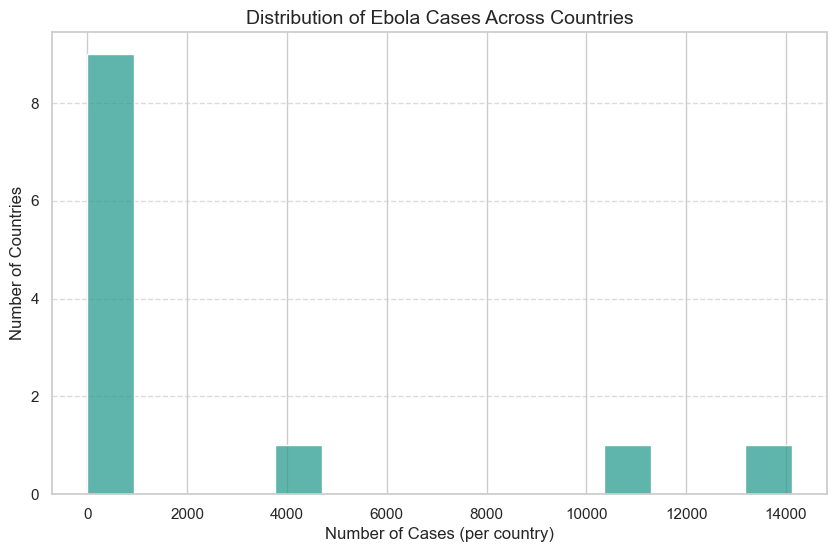

                     Country    value
7               Sierra Leone 14122.00
6                    Liberia 10666.00
5                     Guinea  3804.00
1                       Mali     7.00
9                   Guinea 2     5.00
11  United States of America     4.00
0             United Kingdom     1.00
2                    Senegal     1.00
3                      Spain     0.00
4                    Nigeria     0.00


In [ ]:
# --- Step 1: Filter for 'Cases' only ---
cases = df[df["Indicator_simple"] == "Cases"]

# --- Step 2: Get the latest cumulative value per country ---
latest_cases = (
    cases.sort_values("Date")
         .groupby("Country")
         .tail(1)   # last entry per country
         .reset_index(drop=True)
)

# --- Step 3: Build histogram of case totals ---
plt.figure(figsize=(10, 6))
sns.histplot(latest_cases["value"], bins=15, color="#2a9d8f")

plt.title("Distribution of Ebola Cases Across Countries", fontsize=14)
plt.xlabel("Number of Cases (per country)", fontsize=12)
plt.ylabel("Number of Countries", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# --- Optional sanity check ---
print(latest_cases[["Country", "value"]].sort_values(
    "value", ascending=False).head(10))

This histogram illustrates the distribution of final cumulative Ebola cases across affected countries. Most countries reported very few cases, while a small number — notably Sierra Leone, Liberia, and Guinea — experienced the majority of the outbreak burden. By using the latest cumulative totals per country, the visualization avoids double-counting and reflects the true scale of the epidemic.

### Bar Chart of Cases vs. Deaths by Country

C:\Users\kayjo\AppData\Local\Temp\ipykernel_2948\21435886.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Country")


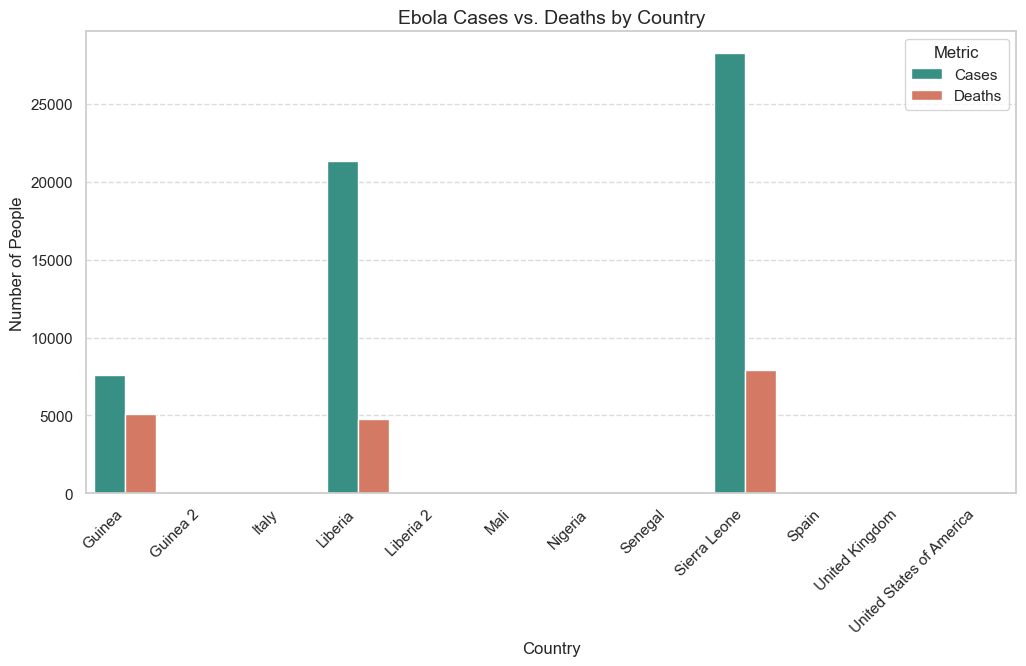

In [ ]:
# --- Step 1: Get latest cumulative totals per country ---
latest = (
    pivot.sort_values("Date")
    .groupby("Country")
    .tail(1)   # last entry per country
    .reset_index(drop=True)
)

# --- Step 2: Keep only countries with nonzero cases/deaths ---
latest = latest[(latest["Cases"] > 0) | (latest["Deaths"] > 0)]

# --- Step 3: Reshape for plotting (long format) ---
long = latest.melt(
    id_vars="Country",
    value_vars=["Cases", "Deaths"],
    var_name="Metric",
    value_name="Count"
)

# --- Step 4: Plot grouped bar chart ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=long,
    x="Country", y="Count", hue="Metric",
    palette={"Cases": "#2a9d8f", "Deaths": "#e76f51"}
)

plt.title("Ebola Cases vs. Deaths by Country", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of People", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

This bar chart compares total Ebola cases and deaths across affected countries. The visualization highlights stark differences in fatality rates: while Sierra Leone, Liberia, and Guinea had the highest case counts, their death totals reveal varying healthcare outcomes and epidemic control. Countries outside West Africa show minimal cases and deaths, underscoring the outbreak’s regional concentration.

### Scatterplot of Cases vs. Deaths

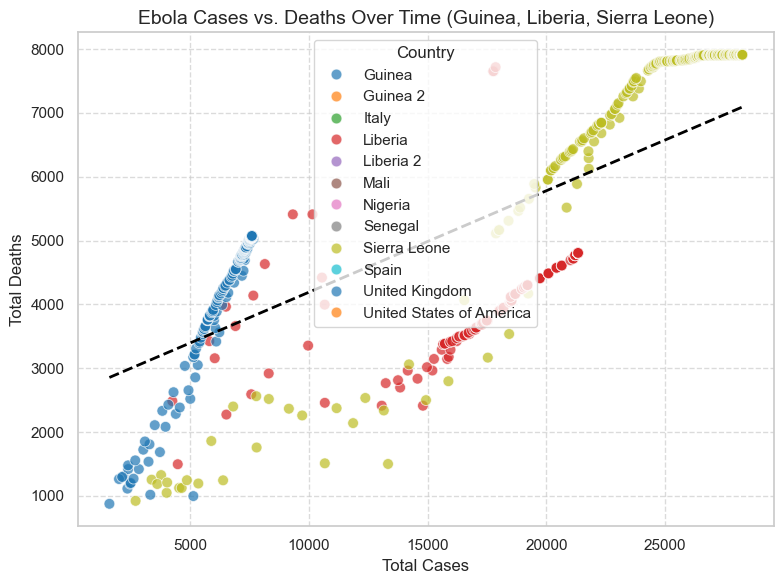

In [ ]:

# --- Filter for affected countries ---
affected_countries = ["Guinea", "Liberia", "Sierra Leone"]
affected = pivot[pivot["Country"].isin(affected_countries)]

# --- Scatter plot with regression line using all dates ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=affected,
    x="Cases", y="Deaths",
    hue="Country",
    palette="tab10", s=60, alpha=0.7
)

# Add regression line across all points
sns.regplot(
    data=affected,
    x="Cases", y="Deaths",
    scatter=False, ci=None, color="black", line_kws={"linewidth": 2, "linestyle": "--"}
)

plt.title(
    "Ebola Cases vs. Deaths Over Time (Guinea, Liberia, Sierra Leone)", fontsize=14)
plt.xlabel("Total Cases", fontsize=12)
plt.ylabel("Total Deaths", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

This scatter plot shows the relationship between Ebola cases and deaths across all reporting dates for Guinea, Liberia, and Sierra Leone. Each dot represents a country’s cumulative totals on a given date. The fitted regression line highlights the strong correlation between cases and deaths, while the spread of points reveals differences in outbreak trajectories and case fatality rates over time.

### Time Series of Cases and Deaths

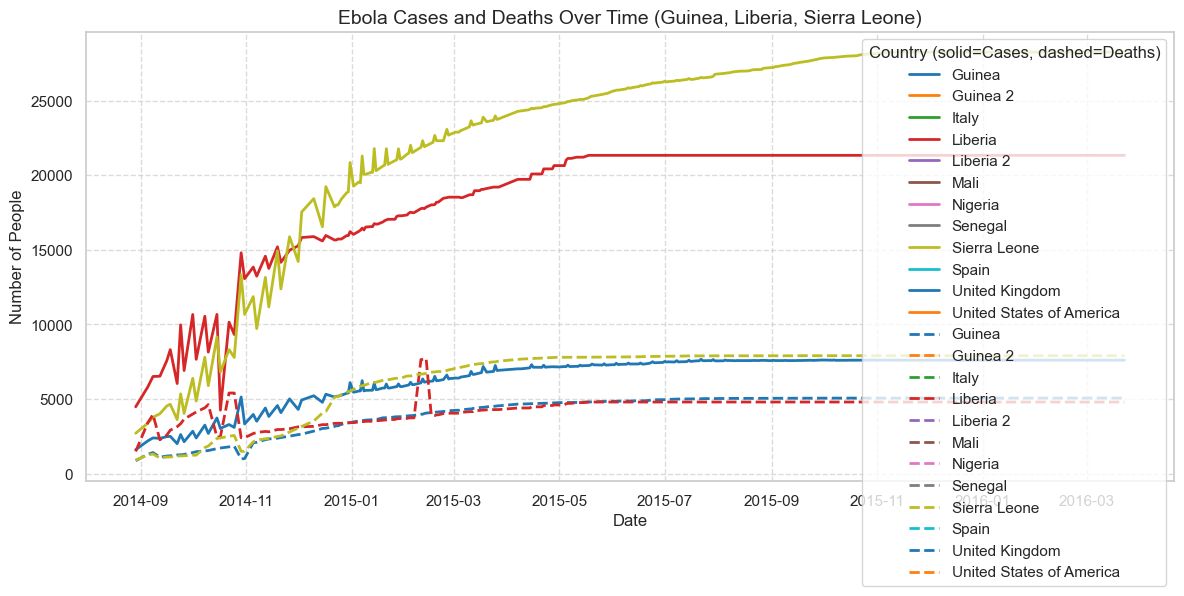

In [ ]:


# --- Filter for affected countries ---
affected_countries = ["Guinea", "Liberia", "Sierra Leone"]
affected = pivot[pivot["Country"].isin(affected_countries)]

# --- Plot time series for cases and deaths ---
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=affected,
    x="Date", y="Cases", hue="Country",
    palette="tab10", linewidth=2
)

sns.lineplot(
    data=affected,
    x="Date", y="Deaths", hue="Country",
    palette="tab10", linewidth=2, linestyle="--"
)

plt.title(
    "Ebola Cases and Deaths Over Time (Guinea, Liberia, Sierra Leone)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of People", fontsize=12)
plt.legend(title="Country (solid=Cases, dashed=Deaths)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Multi-panel Scatter

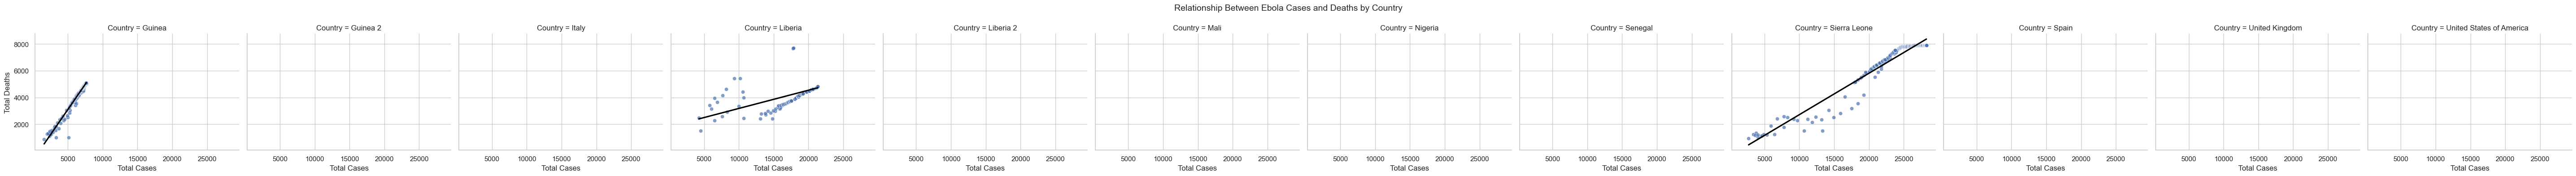

In [ ]:
g = sns.FacetGrid(affected, col="Country", height=4, aspect=1.2)
g.map(sns.scatterplot, "Cases", "Deaths", alpha=0.7)
g.map(sns.regplot, "Cases", "Deaths", scatter=False, ci=None, color="black")

g.set_axis_labels("Total Cases", "Total Deaths")
g.fig.suptitle(
    "Relationship Between Ebola Cases and Deaths by Country", fontsize=14)
plt.tight_layout()
plt.show()

A multi‑panel figure allows direct comparison of outbreak conditions across Guinea, Liberia, and Sierra Leone. By faceting the plots, differences in epidemic progression and case fatality rates become clearer. Sierra Leone’s outbreak curve shows sustained growth, Liberia’s peaks earlier, and Guinea’s remains smaller but proportionally deadlier. This visualization highlights geographic disparities while avoiding clutter from overlapping lines.

### Interactive Plotly Time Series Chart

In [ ]:

# --- Filter for affected countries ---
affected_countries = ["Guinea", "Liberia", "Sierra Leone"]
affected = pivot[pivot["Country"].isin(affected_countries)]

# --- Melt data for plotting ---
long = affected.melt(
    id_vars=["Date", "Country"],
    value_vars=["Cases", "Deaths"],
    var_name="Metric",
    value_name="Count"
)

# --- Interactive line chart ---
fig = px.line(
    long,
    x="Date", y="Count",
    color="Country",
    line_dash="Metric",  # solid for Cases, dashed for Deaths
    title="Interactive Ebola Cases and Deaths Over Time (Guinea, Liberia, Sierra Leone)",
    labels={"Count": "Number of People", "Date": "Date"}
)

# --- Style tweaks ---
fig.update_layout(
    legend_title_text="Country & Metric",
    template="plotly_white"
)

fig.show()

This interactive Plotly chart shows the progression of Ebola cases and deaths over time in Guinea, Liberia, and Sierra Leone. Solid lines represent cumulative cases, while dashed lines represent cumulative deaths. Users can hover to see exact values, zoom into peak outbreak periods, and toggle countries to compare epidemic trajectories interactively.

## Conclusions

The Ebola outbreak was concentrated in Guinea, Liberia, and Sierra Leone, with other countries experiencing minimal cases. Among these three, Sierra Leone reported the highest case counts, while Liberia and Guinea faced smaller but still severe outbreaks. Scatter plots revealed a strong correlation between cases and deaths, though the slopes varied, indicating differences in case fatality rates. Guinea showed a relatively higher fatality proportion, while Liberia’s rate was lower compared to its case volume. Time series charts highlighted the rapid escalation of cases during peak outbreak periods, with Sierra Leone’s epidemic curve rising steeply. Deaths lagged behind cases but followed similar trajectories, underscoring the severity of the epidemic. Grouped bar charts emphasized geographic disparities, showing Sierra Leone consistently reporting higher distributions of cases and deaths, while Guinea’s outbreak was smaller but deadlier proportionally. Taken together, these visualizations demonstrate that while all three countries were severely affected, the scale and fatality rates differed, reflecting variations in healthcare capacity, outbreak response, and population exposure. These differences underscore the importance of regional preparedness and international support in managing epidemics.

## Appendix and References

World Health Organization. Ebola Situation Report – 2014–2016. WHO, 2016.

Centers for Disease Control and Prevention. 2014–2016 Ebola Outbreak in West Africa. CDC, 2016. 

HDX. Ebola Outbreak Dataset. Accessed December 2025.